# Proyecto 1 - Clasificación de imágenes

En este proyecto vamos a probar distintos modelos para clasificar imágenes de dígitos. Para ello, vamos a probar primero modelos tradicionales de Machine Learning, y posteriormente implementaremos redes neuronales fully connected y convolucionales, comparando los resultados proporcionados por cada uno de los modelos.

**NOTA**: En la última celda del notebook se encuentran enlaces a unas carpetas de Google Drive donde se encuentran nuevas imágenes hechas por mi y el modelo exportado para poder probarlo. En las celdas anteriores, se hace un ejemplo de inferencia con una de dichas imágenes.

Vamos primero a importar algunas de las librerías y funciones que necesitaremos a lo largo del ejercicio:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog

In [2]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

## 1. Carga, visualización/exploración y reescalado de las imágenes

El primero paso es cargar el set de datos con el que vamos a trabajar, y hacer un análisis de las características de los datos.

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
import pickle
# Cambiar aquí la ruta
with open('/gdrive/MyDrive/Colab Notebooks/datasets/MNIST/MNIST_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)
with open('/gdrive/MyDrive/Colab Notebooks/datasets/MNIST//MNIST_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

Vamos a, en primer lugar, identificar las dimensiones del dataset:

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Como vemos, el set de entrenamiento está formado por 60.000 imágenes, de 28x28 píxels. Además, la imagen está en escala de grises, ya que únicamente tiene un canal. La variable y es un único vector de 60.000 elementos, que se corresponde con la etiqueta (dígito) de cada una de las imágenes del set X_train. El set de test tiene la misma estructura, pero con 10.000 imágenes.

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

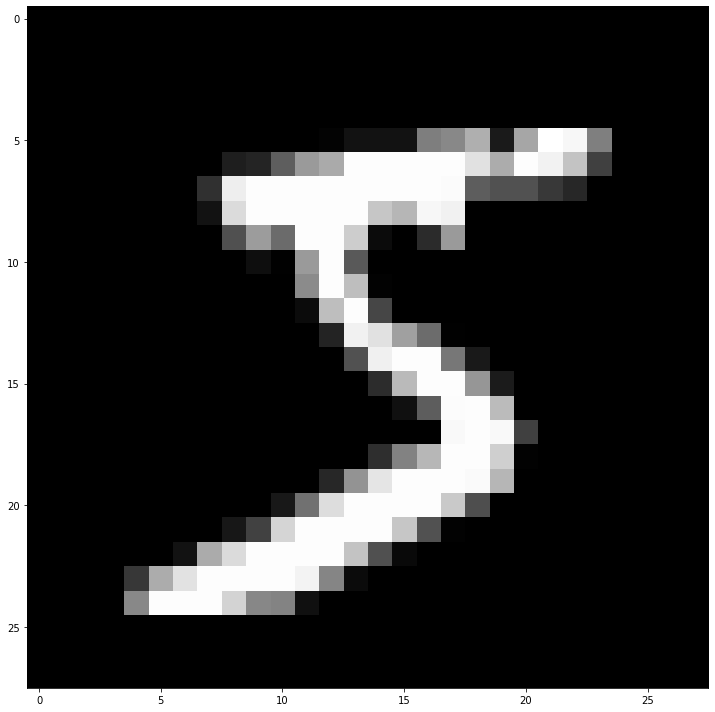

In [ ]:
print(X_train[0])
print(y_train[0])
plt.figure(figsize=(10,10))
io.imshow(X_train[0])

Si nos fijamos en los datos de una imagen, vemos cómo los píxeles están colocados dentro del array siguiendo la forma del dígito. Vamos a probar a plottear otros números:

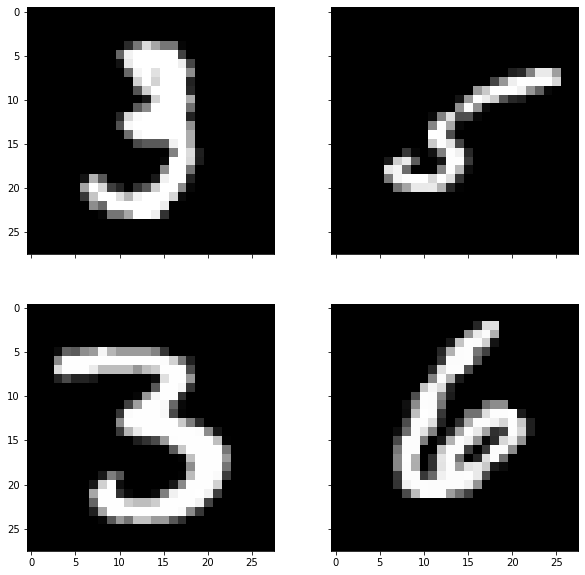

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True, sharey=True, figsize=(10,10))
axs[0,0].imshow(X_train[10,:,:], cmap='gray')
axs[0,1].imshow(X_train[11,:,:], cmap='gray')
axs[1,0].imshow(X_train[12,:,:], cmap='gray')
axs[1,1].imshow(X_train[13,:,:], cmap='gray')
plt.show()

Haciendo una pequeña visualización de las imágenes, vemos que aparecen los dígitos en píxeles blancos y el fondo en negro. Para hacer esto más amigable a la vista, podemos directamente invertir los valores:

In [ ]:
print(np.min(X_train[0]), np.max(X_train[0]))

0 255


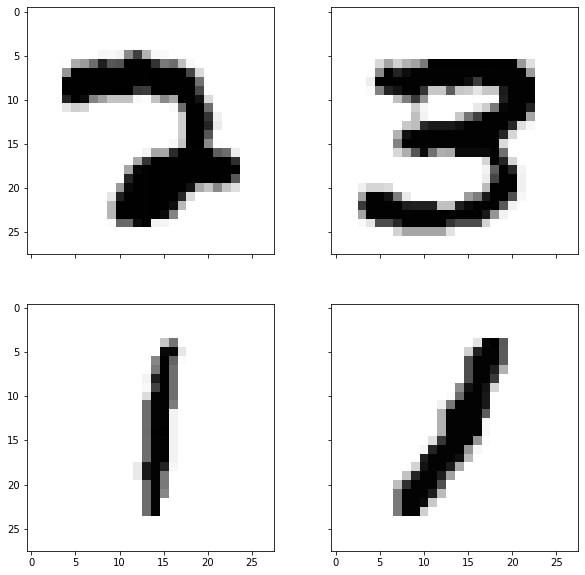

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True, sharey=True, figsize=(10,10))
axs[0,0].imshow(np.max(X_train[120])-X_train[120,:,:], cmap='gray')
axs[0,1].imshow(np.max(X_train[111])-X_train[111,:,:], cmap='gray')
axs[1,0].imshow(np.max(X_train[112])-X_train[112,:,:], cmap='gray')
axs[1,1].imshow(np.max(X_train[113])-X_train[113,:,:], cmap='gray')
plt.show()

Parecen dígitos escritos por humanos. Como vemos, el de arriba a la izquierda es incluso para una persona difícil de identificar (no se aprecia bien si es un 2 o un 7). La resolución de las imágenes es relativamente baja (28x28 px), por lo que se ven muy pixeladas. Sin embargo, puede ser suficiente para identificar los rasgos más característicos.

El siguiente paso es escalar los datos, para que todos se ecuentren dentro de la misma escala, lo cual facilitará la convergencia del modelo y mejorará su precisión:

In [ ]:
X_train_1 = X_train/255 - 0.5
X_test_1 = X_test/255 -0.5

Al escalado anterior le hemos además forzado a que los límites estén entre -0.5 y 0.5.

In [ ]:
print(np.min(X_train_1[0]), np.max(X_train_1[0]))
print(np.min(X_test_1[0]), np.max(X_test_1[0]))

-0.5 0.5
-0.5 0.5


(array([[28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [26.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [26.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
        [26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
        [24.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.],
        [21.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  2.],
        [20.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  4.],
        [20.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  4.],
        [18.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  0.,  6.],
        [15.,  2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  7.],
        [15.,  0.,  0.,  2.,  0.,  1.,  0.,  2.,  1.,  7.],
        [16.,  2.,  1.,  1.,  0.,  0.,  0.,  1.,  2.,  5.],
        [18.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  0.,  5.],
        [15.,  1.,  0.,  2.,  2.,  0.,  

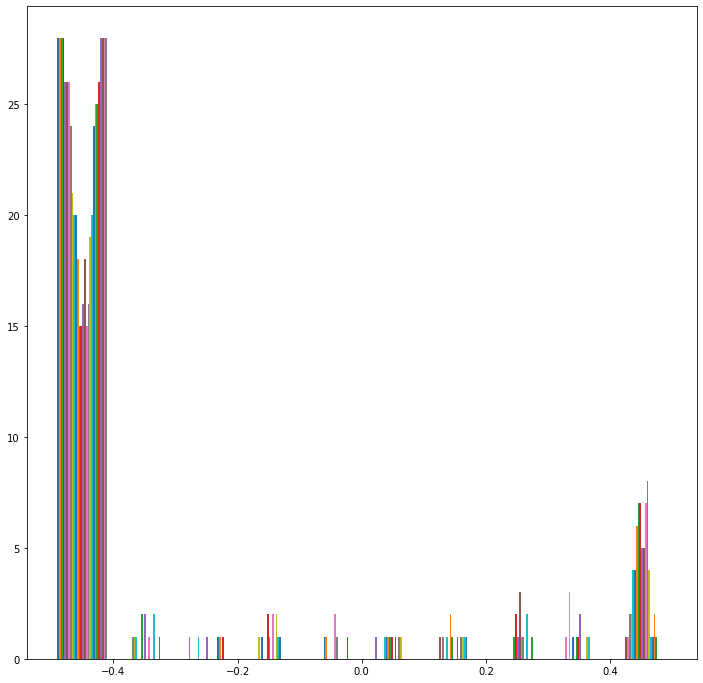

In [ ]:
plt.figure()
plt.hist(X_train_1[0])

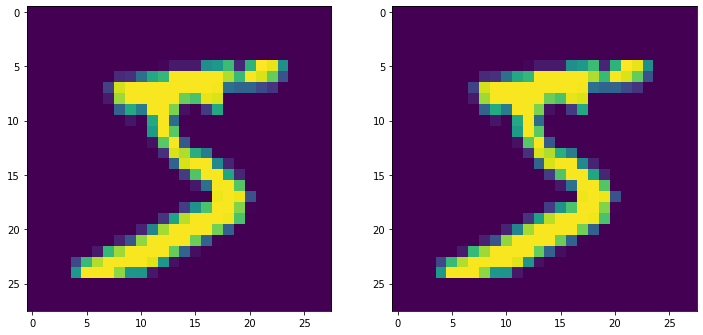

In [ ]:
fig, axs = plt.subplots(1,2, sharey=False)
axs[0].imshow(X_train_1[0])
axs[1].imshow(X_train[0])

Vemos que con el escalado, se sigue manteniendo la misma estructura en la imagen, pero estando ahora todos los valores comprendidos en la misma escala.

## 2. Entrenamiento de modelos de ML tradicionales con HOG features

Vamos ahora a entrenar una serie de modelos de ML para ver cual es capaz de clasificar mejor los dígitos. Pero antes vamos a realizar otra transformación sobre las imágenes: vamos a extraer las HOG features.

In [ ]:
from skimage.feature import hog

Vamos a ver cmómo se visualizarían las Hog features sobre una imagen. Para entender un poco mejor su funcionamiento, vamos a visualizar una misma imagen repetidas veces, cambiando el parámetro pixels_per_cell. Este parámetro indica cuantos píxeles debe haber en cada celda en la que se van a calcular los gradientes.

In [ ]:
hog_images = []
for i in [2,4,7,14,28]:
    fd, hog_image = hog(X_train[0],
                        orientations=6, # 4 direcciones 
                        pixels_per_cell=(i, i), # ventanas de 4x4
                        cells_per_block=(1, 1), 
                        visualize=True, # para obtener el array de visualizacion
                        block_norm='L1')
    hog_images.append(hog_image)

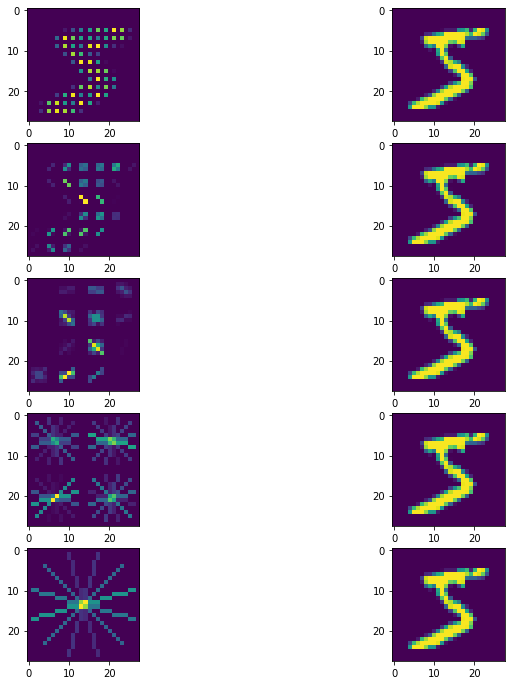

In [ ]:
fig, axs = plt.subplots(len(hog_images),2,sharex=False, sharey=False)
for i in range(len(hog_images)):
    axs[i, 0].imshow(hog_images[i])
    axs[i, 1].imshow(X_train[0])
plt.show()

Vemos que si el número de píxels por celda es muy bajo, las hog features muestran algo muy similar a la propia imagen. Sin embargo, según vamos aumentando este valor, cada celda toma información de más píxeles. Este parámetro será muy importante ajustarlo bien para obtener un buen trade off entre rendimiento y ajuste del modelo. Como hemos visto, si es muy bajo, apenas nos estará proporcionando información nueva relevante, y si es muy grande, estaremos perdiendo una gran cantidad de información.

Para obtener mayor robustez, vamos a concatenar varias escalas (en este caso, usaremos las tres intermedias: 4, 7 y 14 pixels por celda):

In [ ]:
X_train_hog = np.concatenate([np.concatenate([hog(xi, orientations=6, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_train_1],
                                              axis=0) for ppc in [14,7,4]], axis=1)
X_test_hog = np.concatenate([np.concatenate([hog(xi, orientations=6, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test_1],
                                              axis=0) for ppc in [14,7,4]], axis=1)

In [ ]:
X_train_hog.shape

(60000, 414)

Vamos ahora a entrenar distintos modelos con las HOG features que hemos extraído. Vamos a probar con un Random Forest, con una regresión logística y con un SVC, y veremos cual de los tres proporciona mejores resultados. Para cada uno de ellos, mostraremos una serie de métricas, incluyendo la matriz de confusión y la accuracy, dos métricas muy empleadas en la clasificación multi clase.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
## Por temas de computación, haremos la comparativa entre modelos únicamente sobre el 10% de la muestra
X_train_m = X_train_hog[::10,:]
y_train_m = y_train[::10]
X_test_m = X_test_hog[::10,:]
y_test_m = y_test[::10]


## Random Forest model
print('Training Random Forest')
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train_m, y_train_m)
y_pred_rf_train = rfc.predict(X_train_m)
print('RandomForest Score on train set: {}'.format(rfc.score(X_train_m, y_train_m)))
y_pred_rf_test = rfc.predict(X_test_m)
print('RandomForest Score on test set: {}'.format(rfc.score(X_test_m, y_test_m)))
print('--------------')



# ## Support Vector Classifier
# svc = SVC(gamma='auto')
# model = svc.fit(X_train_hog, y_train, verbose=2)
# print('Support Vector Classifier | Train set')
# svcScore(svc, X_train_hog, y_train)
# print('Support Vector Classifier | Test set')
# svcScore(svc, X_test_hog, y_test)

## Logistic Regression
print('Training Logistic Regression')
lrc = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)
lrc.fit(X_train_m, y_train_m)
y_pred_lr_train = lrc.predict(X_train_m)
print('Logistic Regression Score on train set: {}'.format(lrc.score(X_train_m, y_train_m)))
y_pred_lr_test = lrc.predict(X_test_m)
print('Logistic Regression Score on test set: {}'.format(lrc.score(X_test_m, y_test_m)))
print('--------------')



# ## K Neighbors Classifier
print('Training K Nearest Neighbors')
knc = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
knc.fit(X_train_m, y_train_m)
y_pred_kn_train = knc.predict(X_train_m)
print('K Neighbors Score on train set: {}'.format(knc.score(X_train_m, y_train_m)))
y_pred_kn_test = knc.predict(X_test_m)
print('K Neighbors Score on test set: {}'.format(knc.score(X_test_hog, y_test)))


Training Random Forest
RandomForest Score on train set: 1.0
RandomForest Score on test set: 0.962
--------------
Training Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression Score on train set: 0.9866666666666667
Logistic Regression Score on test set: 0.951
--------------
Training K Nearest Neighbors
K Neighbors Score on train set: 0.9555
K Neighbors Score on test set: 0.9369


Si nos fijamos en cómo predicen los modelos empleando el set completo de test:

In [ ]:
print('Random Forest Score on test set: {}'.format(rfc.score(X_test_hog, y_test)))
print('Logistic Regression Score on test set: {}'.format(lrc.score(X_test_hog, y_test)))
print('K Neighbors Score on test set: {}'.format(knc.score(X_test_hog, y_test)))


Random Forest Score on test set: 0.9666
Logistic Regression Score on test set: 0.9519
K Neighbors Score on test set: 0.9369


El modelo con la mayor la precisión (accuracy) es el Random Forest, llegando a alcanzar un 0.966 de acierto en el conjunto de test. Aunque los otros dos modelos son un poco peores, también proporcionana tasas de acierto muy altas, tanto en el set de entrenamiento como en el de test. Se observa que todos los modelos sufren cierto grado de sobreajuste, y por tanto sería necesario realizar un buen ajuste de hiperparámetros para evitar el overfitting.

## 3. Grid search de hiperparámetros de los modelos y HOG features

El siguiente paso consistirá en crear una pipeline para automatizar el proceso de transformación de datos y entrenamiento del modelo. Además, la usaremos también para realizar un grid search de hiperparámetros, y definir así los mejores modelos posibles.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

Vamos a crear un par de clases que nos permitirán automatizar las transformaciones de escalado y extracción de Hog features.

In [6]:
class Scaler(BaseEstimator, TransformerMixin):
    """This class will scale the data as: x = (x/a) - b"""
    def __init__(self, a, b):
        self.a = a
        self.b = b
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return ((X/self.a) - self.b)


class HogFeaturesExtraction(BaseEstimator, TransformerMixin):
    """
    This class will create a new dataset by extracting the hog features of 
    the input dataset
    
    param orientations: the number of orientations in which the gradient will be calculated
    param ppc: number of pixels per cell. It's recommended that the value of ppc is not lower than 4, as
                three scales will be concatenated for a better performance (ppc, ppc/2 and ppc/4)
    param cpb: number of cells per block
    """
    def __init__(self, orientations=6, ppc=7, cpb=1):
        self.orientations = orientations
        self.ppc = ppc
        self.cpb = cpb
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_hog = np.concatenate([np.concatenate([hog(xi, orientations=self.orientations, 
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(self.cpb, self.cpb), 
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X],
                                              axis=0) for ppc in [self.ppc,int(self.ppc/2),int(self.ppc/4)]], axis=1)
        return X_hog      

Ahora vamos a definir los pasos que irán dentro de los pipelines. Por lo general, haremos un pipeline para cada modelo. Cada pipeline contendrá las transformaciones de escalado y de extracción de hog features y por último el modelo correspondiente.

In [ ]:
scaling_step = ('scaler', Scaler(255.0, 0.5))
hog_step = ('hog_features', HogFeaturesExtraction())
model_rfc = ('rfc', RandomForestClassifier(n_jobs=-1))
model_lrc = ('lrc', LogisticRegression(n_jobs=-1))
model_knc = ('knc', KNeighborsClassifier(n_jobs=-1))

Vamos ahora a construir el pipeline para el RandomForestClassifier, haciendo además sobre él una búsqueda de hiperparámetros

In [ ]:
# Creación del pipeline con los steps necesarios
pipe_rfc = Pipeline([scaling_step, hog_step, model_rfc])

# Definición de los hiperparámetros y los valores sobre los que queremos hacer la búsqueda
param_grid_rfc = {'hog_features__orientations': [4,6,8], 
                 'hog_features__ppc': [12,14,16], 
                 'rfc__max_depth': [5,8,12], 
                 'rfc__min_samples_leaf': [2,4,6] 
                 }

# Realizamos el grid search sobre el pipeline creado
grid_search_rfc = GridSearchCV(pipe_rfc, cv=3, param_grid=param_grid_rfc, n_jobs=-1, verbose=2)

# Una vez realizado el grid search, entrenamos el modelo empleando la mejor combinación de hiperparámetros encontrada.
grid_search_rfc.fit(X_train[::10,:,:], y_train[::10])


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   54.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler', Scaler(a=255.0, b=0.5)),
                                       ('hog_features',
                                        HogFeaturesExtraction(cpb=1,
                                                              orientations=6,
                                                              ppc=7)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                        

In [ ]:
print('Random Forest Score on test set after grid search: {}'.format(grid_search_rfc.score(X_test, y_test)))

También podemos ver los resultados de la búsqueda de hiperparámetros. Por ejemplo, podemos ver la mejor combinación, o podemos ver también una lista con el resultado que proporciona cada combinación sobre el conjunto de test.

In [ ]:
grid_search_rfc.best_params_

{'hog_features__orientations': 6,
 'hog_features__ppc': 16,
 'rfc__max_depth': 12,
 'rfc__min_samples_leaf': 2}

In [ ]:
results = pd.DataFrame(grid_search_rfc.cv_results_).sort_values(by='mean_test_score', ascending=False)

In [ ]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_hog_features__orientations', 'param_hog_features__ppc',
       'param_rfc__max_depth', 'param_rfc__min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
results[['param_hog_features__orientations', 'param_hog_features__ppc', 'param_rfc__max_depth','param_rfc__min_samples_leaf', 'mean_test_score']]

,param_hog_features__orientations,param_hog_features__ppc,param_rfc__max_depth,param_rfc__min_samples_leaf,mean_test_score
51,6,16,12,2,0.950333
52,6,16,12,4,0.948167
78,8,16,12,2,0.947667
33,6,12,12,2,0.947000
79,8,16,12,4,0.946333
...,...,...,...,...,...
20,4,16,5,6,0.899667
1,4,12,5,4,0.898500
2,4,12,5,6,0.897833
55,8,12,5,4,0.897500


Si ahora quisiéramos exportar el mejor modelo, podríamos exportar la pipeline completa. También podríamos exportar dos pipelines diferenciadas: una para las transformaciones de los datos, y otra con la información del modelo:

In [ ]:
# Creación del pipeline de datos:
data_pipeline = Pipeline([scaling_step, hog_step])

# Creación del pipeline del modelo, con los mejores parámetros encontrados en la ejecución anterior
model_pipeline = Pipeline([('model', RandomForestClassifier(max_depth=12, min_samples_leaf=2, n_jobs=-1))])

In [ ]:
# Store data (serialize)

with open('/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/data_pipeline.pkl', 'wb') as ff:
    pickle.dump(data_pipeline, ff)

with open('/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/model_pipeline.pkl', 'wb') as ff:
    pickle.dump(model_pipeline, ff)

Vamos ahora a crear los pipelines de los otros dos modelos. En primer lugar, creamos el pipeline para la regresión logística. Emplearemos como hiperparámetro de la regresión el método de regularización o penalty a usar. Este parámetro será necesario para controlar el sobreajuste, que ya vimos anteriormente que aparece al emplear este modelo.

In [ ]:
# Creación del pipeline con los steps necesarios
pipe_lrc = Pipeline([scaling_step, hog_step, model_lrc])

# Definición de los hiperparámetros y los valores sobre los que queremos hacer la búsqueda
param_grid_lrc = {'hog_features__orientations': [4,6,8], 
                 'hog_features__ppc': [12,14,16],
                 'lrc__penalty': ['l1','l2'], 
                 }

# Realizamos el grid search sobre el pipeline creado
grid_search_lrc = GridSearchCV(pipe_lrc, cv=3, param_grid=param_grid_lrc, n_jobs=-1, verbose=2)

# Una vez realizado el grid search, entrenamos el modelo empleando la mejor combinación de hiperparámetros encontrada.
grid_search_lrc.fit(X_train[::10,:,:], y_train[::10])

# Mostramos el mejor resultado
print(grid_search_lrc.best_params_)

print('Logistic Regression Score on test set after grid search: {}'.format(grid_search_lrc.score(X_test, y_test)))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.8min finished


{'hog_features__orientations': 8, 'hog_features__ppc': 16, 'lrc__penalty': 'l2'}
Logistic Regression Score on test set after grid search: 0.9577


Por último, realizamos el grid search sobre el modelo de KNeighbors

In [ ]:
# Creación del pipeline con los steps necesarios
pipe_knc = Pipeline([scaling_step, hog_step, model_knc])

# Definición de los hiperparámetros y los valores sobre los que queremos hacer la búsqueda
param_grid_knc = {'hog_features__orientations': [4,6,8], 
                 'hog_features__ppc': [12,14,16], 
                 'knc__n_neighbors': [3,5,8],
                 }

# Realizamos el grid search sobre el pipeline creado
grid_search_knc = GridSearchCV(pipe_knc, cv=3, param_grid=param_grid_knc, n_jobs=-1, verbose=2)

# Una vez realizado el grid search, entrenamos el modelo empleando la mejor combinación de hiperparámetros encontrada.
grid_search_knc.fit(X_train[::10,:,:], y_train[::10])

# Mostramos el mejor resultado
print(grid_search_knc.best_params_)

print('K Neighbors Score on test set after grid search: {}'.format(grid_search_knc.score(X_test, y_test)))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.0min finished


{'hog_features__orientations': 6, 'hog_features__ppc': 14, 'knc__n_neighbors': 5}
K Neighbors Score on test set after grid search: 0.9316


## 4. Diseño de red neuronal “fully connected”, no convolucional.

Vamos ahora a probar una red neuronal fully connected para clasificar las imágenes. 

In [7]:
import torch
from torch import nn
from torch.utils import data

In [8]:
X_train_t0 = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
y_train_t0 = torch.tensor(y_train, requires_grad=False, dtype=torch.long)
X_test_t0 = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
y_test_t0 = torch.tensor(y_test, requires_grad=False, dtype=torch.long)

X_train_t = X_train_t0[::10,:,:]
y_train_t = y_train_t0[::10]
X_test_t = X_test_t0[::10,:,:]
y_test_t = y_test_t0[::10]

Definimos una clase que será nuestra red neuronal. La arquitectura de la misma consistirá en 3 capas lineales, cuyas funciones de activación serán funciones ReLU. 

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
## Definimos una clase, que será nuestra red neuronal
class NeuralNetworkFC(nn.Module):
    def __init__(self):
        super(NeuralNetworkFC, self).__init__()
        self.flatten = nn.Flatten()
        self.sequence = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.Softmax(dim=1))

    def forward(self, x):
        x = self.flatten(x)
        probs = self.sequence(x)
        return probs
            

Para mejorar el rendimiento, enviamos la red neuronal y los datos para que sean procesados en la GPU

In [ ]:
model = NeuralNetworkFC().cuda()
X_train_t = X_train_t.cuda()
X_test_t = X_test_t.cuda()
y_train_t = y_train_t.cuda()
y_test_t = y_test_t.cuda()

Ahora vamos a hacer un simple forward pass, para comprobar que la red funciona correctamente

In [ ]:
probabilities = model(X_train_t)
output = probabilities.argmax(1)

In [ ]:
output

tensor([2, 6, 2,  ..., 6, 6, 6], device='cuda:0')

In [ ]:
probabilities.shape

torch.Size([6000, 10])

## 5. Entrenamiento red neuronal “fully connected”.

Vamos ahora a proceder a entrenar la red neuronal anterior. Para ello, seguiremos los siguientes pasos:

1. Inicialización aleatoria de parámetros
2. Entrenamiento de la red, que consistirá en un bucle que en cada paso calculará: 
    - Forward propagation: cálculo de las probabilidades y la función de loss
    - Backward propagation: cálculo de los gradientes y optimización de pesos

Vamos antes de nada a ver qué parámetros tiene la red:

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape) 

sequence.0.weight torch.Size([128, 784])
sequence.0.bias torch.Size([128])
sequence.2.weight torch.Size([32, 128])
sequence.2.bias torch.Size([32])
sequence.4.weight torch.Size([10, 32])
sequence.4.bias torch.Size([10])


Vemos que tiene distintos tensores de parámetros (*Weight* y *Bias*). Estos corresponden a los pesos y a los términos bias de cada capa de la red. Ahora inicializaremos los parámetros de la red, empleando un inicialización *Xavier* sobre los pesos de las capas. Los términos de bias los inicializaremos con un valor de 0.01.

In [12]:
# Inicializamos los parámetros de la red neuronal
def init_params(net):
    for nam, param in net.named_parameters():
        if 'weight' in nam:
            nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

# init_params(model)

También vamos a generar una funciones que nos calculen el porcentaje de acierto de la red después de hacer un forward pass:

In [10]:
def prediction(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

In [11]:
def score(x, y, forw):
    with torch.no_grad():
        y_pred = prediction(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

Si calculamos el porcentaje de acierto antes de haber entrenado la red, deberíamos obtener algo alrededor del 10%, que sería el acierto que tendríamos si escogiéramos el resultado al azar.

In [ ]:
print(score(X_train_t, y_train_t, model))

0.101


Vamos ahora a definir los hiperparámetros del entrenamiento. Entre ellos:
- **Número de *epochs*:** número de veces a iterar sobre el dataset.
- **Batch size**: número de imágenes que serán propagadas antes de actualizar los pesos.
- **Learning rate**: parámetro de la función de optimización que indica la cantidad de veces que se calculan los pesos en cada batch/epoch. 

In [ ]:
epochs = 3000
batch = 64
learning_rate = 0.001

#### Loss function

La función de loss nos indicará la diferencia entre los valores predichos y los valores reales en cada iteración. Es por tanto la función que queremos optimizar/minimizar. Al tratarse de un problema de clasificación, emplearemos la función NLLLoss.

In [13]:
def loss_function(x, y, forw):
    return nn.functional.nll_loss(forw(x), y)

In [ ]:
loss_function(X_train_t, y_train_t, model)

tensor(-0.1007, device='cuda:0', grad_fn=<NllLossBackward>)

#### Función de optimización

Emplearemos la función *Stochastic Gradient Descent (SGD)*. el objetivo es ajustar los pesos de la red neuronal de modo que la función de Loss sea mínima. Esto se consigue siguiendo el camino de máxima pendiente (gradiente máximo), para así llegar al mínimo lo más rápido posible. El parámetro *weight decay* sirve para regularizar y así disminuir los posibles problemas de sobreajuste.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.02)

#### Generador de mini-batches

Entrenar el modelo con batches (conjuntos de imágenes) en cada paso de iteración puede ayudarnos a disminuir el overfitting. 

In [ ]:
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t, y_train_t), 
                                       batch_size=batch, shuffle=True) # shuffle: reordena el dataset en cada epoch

#### Función de entrenamiento final

Una vez definidas las distintas partes que compondrán el entrenamiento, procedemos a unificarlas en una misma función:


In [ ]:
def training(x, y, net, loss_f, opt_f):
    # Forward prop1
    loss = loss_f(x, y, net)

    #Backward prop
    opt_f.zero_grad()
    loss.backward()
    opt_f.step()

    #Calculate score 
    sc = score(X_train_t, y_train_t, net)

    return loss.item(), sc

Una vez definido un paso de entrenamiento, vamos a iterar sobre él:

In [14]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
do_seeds(0)

In [ ]:
do_seeds(11)  ## en epoch 0 da un score de 0.1765
init_params(model)
for i in range(epochs):
    for x_b, y_b in mini_b:
        output = training(x_b, y_b, model, loss_function, optimizer)

    if i%(int(epochs/10)) == 0:
        print("Epoch: {}, Loss: {:.4f}, Score: {:.4f}".format(i, output[0], output[1]))

Epoch: 0, Loss: -0.1041, Score: 0.0680
Epoch: 300, Loss: -0.7499, Score: 0.7540
Epoch: 600, Loss: -0.8455, Score: 0.7878
Epoch: 900, Loss: -0.7668, Score: 0.7938
Epoch: 1200, Loss: -0.8088, Score: 0.8862
Epoch: 1500, Loss: -0.8706, Score: 0.8867
Epoch: 1800, Loss: -0.9284, Score: 0.9887
Epoch: 2100, Loss: -0.9733, Score: 0.9898
Epoch: 2400, Loss: -0.9930, Score: 0.9905
Epoch: 2700, Loss: -0.9746, Score: 0.9907


Vemos que según van avanzando las iteraciones (epochs), va disminuyendo el Loss y va aumentando el porcentaje de acierto. Llega a un punto en el que se satura y ya no encuentra mejores soluciones. Dependiendo de cómo se inicialicen los pesos y de los hiperparámetros escogidos se podrían encontrar distintos valores de score.

Veamos cuales son los resultados finales para train y para test:

In [ ]:
print('Train score: {:.4f}'.format(score(X_train_t, y_train_t, model)))
print('Test score: {:.4f}'.format(score(X_test_t, y_test_t, model)))
print('Test score sobre el test set completo: {:.4f}'.format(score(X_test_t0.cuda(), y_test_t0.cuda(), model)))

Train score: 0.9935
Test score: 0.9470
Test score sobre el test set completo: 0.9503


Vemos que se consiguen muy buenas soluciones: 99% de acierto en el set de training, aunque encontramos cierto grado de sobreajuste (94.9% de acierto en el set de test)

In [ ]:
path = '/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/'
item = 'fcnn.pth'
torch.save(model.state_dict(), path + item)

In [ ]:
_, y_pred_fcnn_train = torch.max(model(X_train_t),1)
_, y_pred_fcnn_test = torch.max(model(X_test_t),1)

## 6. Diseño de red neuronal convolucional

Vamos ahora a generar una red neuronal convolucional, para ver si podemos lograr mejores resultados

In [15]:
## Definimos una clase, que será nuestra red neuronal
class NeuralNetworkConv(nn.Module):
    def __init__(self):
        super(NeuralNetworkConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, 
                      kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=15, out_channels=10, 
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(in_features=490, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        probs = self.sequence(x)
        return probs

In [16]:
model_cnn = NeuralNetworkConv().cuda()

In [ ]:
model_cnn

NeuralNetworkConv(
  (sequence): Sequential(
    (0): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(15, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=490, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)

In [ ]:
for name, param in model_cnn.named_parameters():
    print(name, param.shape) 

sequence.0.weight torch.Size([15, 1, 5, 5])
sequence.0.bias torch.Size([15])
sequence.3.weight torch.Size([10, 15, 3, 3])
sequence.3.bias torch.Size([10])
sequence.7.weight torch.Size([10, 490])
sequence.7.bias torch.Size([10])


In [17]:
# Para casar las dimensiones de los datos con las del módulo Conv2d, incluimos un 1 que indica el número de canales de la imagen.
X_train_t2 = torch.tensor(X_train, requires_grad=False, dtype=torch.float).unsqueeze(1).cuda() 
X_train_t2.shape
y_train_t2 = torch.tensor(y_train, requires_grad=False, dtype=torch.long).cuda()
X_test_t2 = torch.tensor(X_test, requires_grad=False, dtype=torch.float).unsqueeze(1).cuda() 
y_test_t2 = torch.tensor(y_test, requires_grad=False, dtype=torch.long).cuda()


In [ ]:
probabilities_cnn = model_cnn(X_train_t2)
output_cnn = probabilities_cnn.argmax(1)

In [ ]:
probabilities_cnn.shape

torch.Size([60000, 10])

In [ ]:
output_cnn

tensor([8, 8, 2,  ..., 2, 8, 8], device='cuda:0')

In [ ]:
score(X_train_t2, y_train_t2, model_cnn)

0.12481666666666667

## 7. Entrenamiento red neuronal convolucional

Vamos a proceder a entrenar la CNN creada anteriormente.

In [18]:
epochs = 2000
batch = 500
learning_rate = 0.001

Definimos las funciones de Loss y de optimización. En este caso, emplearemos la función Adam.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), weight_decay=0.005, lr=learning_rate)

In [ ]:
X_train_t3 = X_train_t2[::10,:,:]
y_train_t3 = y_train_t2[::10]
X_test_t3 = X_test_t2[::10,:,:]
y_test_t3 = y_test_t2[::10]
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t3, y_train_t3), 
                                       batch_size=batch, shuffle=True) # shuffle: reordena el dataset en cada epoch

In [ ]:
X_train_t3.shape

torch.Size([6000, 1, 28, 28])

In [23]:
def training_cnn(x, y, net, loss_f, opt_f):
    # Forward prop1
    output = net(x)
    loss = loss_f(output, y)

    #Backward prop
    opt_f.zero_grad()
    loss.backward()
    opt_f.step()

    #Calculate score 
    sc = score(X_train_t2, y_train_t2, net)

    return loss.item(), sc

In [ ]:
do_seeds(11)
init_params(model_cnn)
# init_params(model)
for i in range(epochs):
    for x_b, y_b in mini_b:
        output = training_cnn(x_b, y_b, model_cnn, loss_fn, optimizer)

    if i%(int(epochs/10)) == 0:
        print("Epoch: {}, Loss: {:.4f}, Score: {:.4f}".format(i, output[0], output[1]))

Epoch: 0, Loss: 2.2127, Score: 0.2317
Epoch: 200, Loss: 1.4983, Score: 0.9700
Epoch: 400, Loss: 1.4618, Score: 0.9982
Epoch: 600, Loss: 1.4638, Score: 0.9982
Epoch: 800, Loss: 1.4634, Score: 0.9983
Epoch: 1000, Loss: 1.4632, Score: 0.9985
Epoch: 1200, Loss: 1.4620, Score: 0.9965
Epoch: 1400, Loss: 1.4616, Score: 0.9978
Epoch: 1600, Loss: 1.4638, Score: 0.9983
Epoch: 1800, Loss: 1.4613, Score: 0.9987


In [ ]:
print('Train score: {:.4f}'.format(score(X_train_t3, y_train_t3, model_cnn)))
print('Test score: {:.4f}'.format(score(X_test_t3, y_test_t3, model_cnn)))
print('Test score en el test set completo: {:.4f}'.format(score(X_test_t2, y_test_t2, model_cnn)))

Train score: 0.9990
Test score: 0.9730
Test score en el test set completo: 0.9765


In [ ]:
path = '/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/'
item = 'cnn.pth'
torch.save(model_cnn.state_dict(), path + item)

In [ ]:
_, y_pred_cnn_train = torch.max(model_cnn(X_train_t3),1)
_, y_pred_cnn_test = torch.max(model_cnn(X_test_t3), 1)

La red neuronal convolucional es el modelo que mejor acierto muestra tanto en el conjunto de train (99.9%) como en el de test (97.3%). Existe cierto grado de sobreajuste, pero no es elevado y tampoco es muy preocupante al ser tan alta la precisión.

## 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL

Ahora que ya hemos definido todos los modelos y los hemos entrenado, vamos a compararlos entre sí. Las matrices de confusión de cada modelo son:

In [ ]:
def models_score(y_pred, y):
    print(confusion_matrix(y, y_pred, labels=range(10)))
    print('F1 Score: ', f1_score(y_pred, y, average='macro'))
    print('Accuracy: ', accuracy_score(y_pred, y))
    print('Precision: ', precision_score(y_pred, y, average='macro'))
    print('Recall: ', recall_score(y_pred, y, average='macro'))

In [ ]:
text = 'Matriz de confusión del modelo '

## Modelo Random Forest
print(text + 'Random Forest:')
models_score(y_pred_rf_test, y_test[::10])

## Modelo Linear Regression
print(text + 'Linear regression:')
models_score(y_pred_lr_test, y_test[::10])

## Modelo KN Neighbors
print(text + 'K Nearest Neighbors:')
models_score(y_pred_kn_test, y_test[::10])


## Modelo Fully Connected NN
y_pred_fcnn_test_1 = y_pred_fcnn_test.cpu().detach().numpy()
print(text + 'Fully Connected Neural Network:')
models_score(y_pred_fcnn_test_1, y_test[::10])

## Modelo  Convolutional NN
y_pred_cnn_test_1 = y_pred_cnn_test.cpu().detach().numpy()
print(text + 'Convolutional Neural Network:')
models_score(y_pred_cnn_test_1, y_test[::10])

Matriz de confusión del modelo Random Forest:
[[ 95   0   0   0   0   0   1   0   0   0]
 [  0 113   0   0   1   0   0   1   0   0]
 [  0   0  89   0   0   0   0   0   0   0]
 [  0   0   0 121   0   1   0   0   0   1]
 [  0   0   1   0  82   0   1   0   0   3]
 [  1   1   0   4   0  91   1   1   0   0]
 [  2   0   1   0   0   1  84   0   0   0]
 [  0   1   0   0   1   0   0 103   0   6]
 [  0   0   0   1   1   0   1   1  85   0]
 [  1   0   0   1   1   0   0   3   1  96]]
F1 Score:  0.9590748053598421
Accuracy:  0.959
Precision:  0.9587220918408104
Recall:  0.9598497587898429
Matriz de confusión del modelo Linear regression:
[[ 93   0   0   0   0   1   1   0   1   0]
 [  0 109   0   0   1   0   3   1   1   0]
 [  0   0  86   2   0   0   0   0   1   0]
 [  0   0   0 119   0   3   0   0   1   0]
 [  0   0   0   0  83   0   1   0   0   3]
 [  1   1   0   3   1  91   1   0   0   1]
 [  2   0   0   0   1   2  83   0   0   0]
 [  0   2   0   0   0   0   0 107   0   2]
 [  0   0   0   0   1  

Por lo general, todos los modelos seleccionados tienen una precisión muy alta. Mostrando su matriz de confusión sobre el conjunto de test reducido, se ve que apenas hay valores erróneas, y por lo tanto los modelos responden muy bien. El modelo con mejor valor de Accuracy en el conjunto de test (tanto en el reducido como en el global) es la red neuronal convolucional, lo cual tiene sentido ya que su eficacia para problemas de clasificación de imágenes está comprobada.

El segundo mejor modelo es el RandomForest, superando incluso a la red neuronal fully connected. Esto es muy interesante ya que el Random Forest puede ser mucho menos costosos computancionalmente que la red neuronal, consiguiendo resultados mejores. 

El peor de los modelos es el K Nearest Neighbors, el cual además es el que más tiempo tarda en entrenar de los modelos de Machine Learning clásico.

## 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos

Ahora que ya hemos visto unos cuantos modelos distintos, vamos a ver cual de ellos es más robusto frente a traslaciones horizontales de la imagen. Para ello, tomaremos una imagen y crearemos distintas versiones de la misma pero con una traslación en el eje 'x' de sus píxeles. De este modo, comprobaremos que modelo es capaz de predecir mejor un dígito en caso de que este esté '*deformado*'.

In [ ]:
traslation = np.array(list(range(-14,14)))
X_test_tras_1 = [np.roll(X_test[::10,:,:], i, axis=2) for i in traslation]

In [ ]:
X_test_tras = np.array(X_test_tras_1)

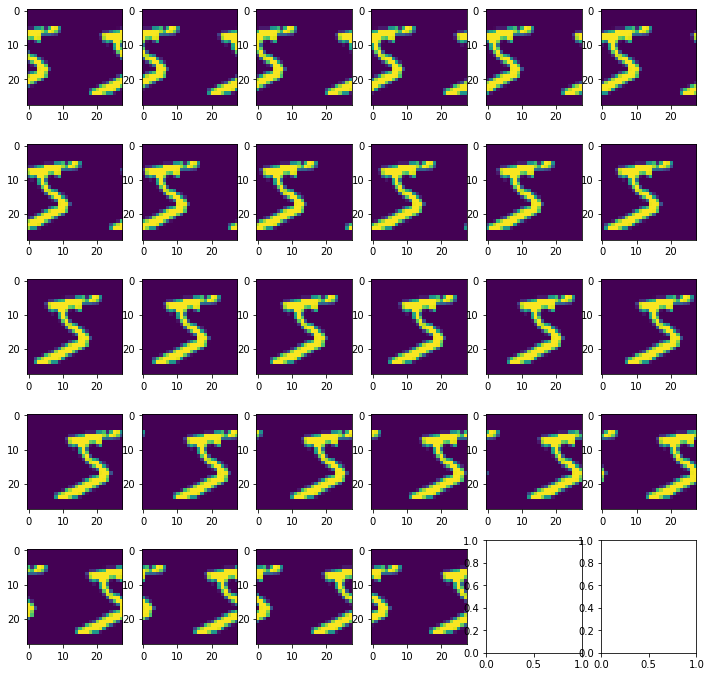

In [ ]:
im = io.imshow_collection([xi[0,:,:] for xi in X_test_tras])

In [ ]:
rfc_scores = [grid_search_rfc.score(xi, y=y_test[::10]) for xi in X_test_tras]

In [ ]:
print(grid_search_rfc.score(X_test, y_test))

0.9627


In [ ]:
lrc_scores = [grid_search_lrc.score(xi, y=y_test[::10]) for xi in X_test_tras]

In [ ]:
knc_scores = [grid_search_knc.score(xi, y=y_test[::10]) for xi in X_test_tras]

In [ ]:
fcnn_scores = [score(torch.tensor(xi.reshape(xi.shape[0],-1), requires_grad=False, dtype=torch.float).cuda(), 
                      y_test_t, model) for xi in X_test_tras]

In [ ]:
cnn_scores = [score(torch.tensor(xi, requires_grad=False, dtype=torch.float).unsqueeze(1).cuda(), 
                      y_test_t, model_cnn) for xi in X_test_tras]

In [ ]:
scores_d = pd.DataFrame(
     {'Random Forest Classifier': rfc_scores,
      'Logistic Regression': lrc_scores,
      'K Nearest Neighbors Classifier': knc_scores,
      'Fully Connected Neural Network': fcnn_scores,
      'Convolutional Neural Network': cnn_scores}, 
      index=traslation)

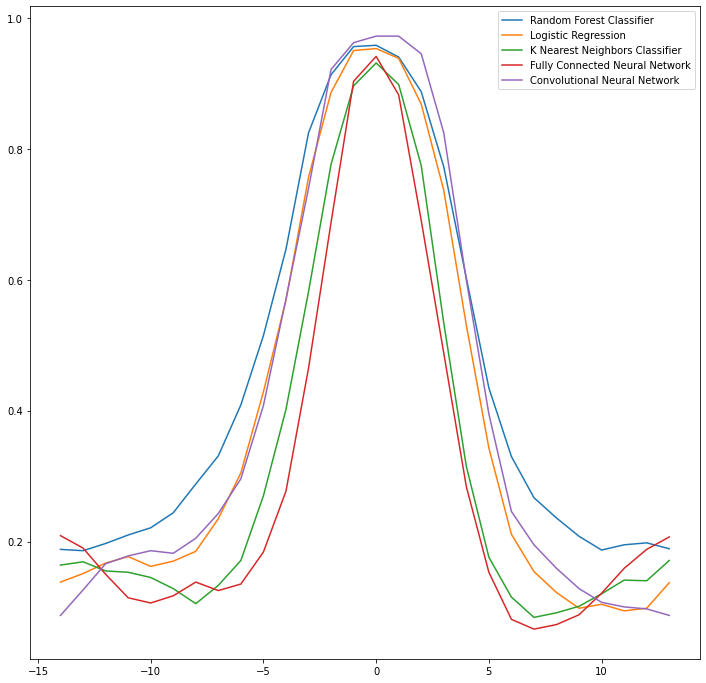

In [ ]:
scores_d.plot()

Como vemos en la imagen, la red CNN es la que consigue mejores resultados en el set de test cuando la imagen está completamente centrada. Sin embargo, parece que ante traslaciones horizontales, el modelo RandomForest es el más robusto, aunque sin llegar a mostrar cualidades excepcionales. Resulta extraño ya que una de las capacidades de las redes convolucionales es su robustez frente a transformaciones en las imágenes como las traslaciones que acabamos de probar.

## 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido

El último paso consiste en crear una función que permita adaptar nuevas imágenes para que sirvan como input al modelo. Tras esto, exportaremos dicha función de preporcesado como un pipeline de sklearn y también la red neuronal convolucional entrenada (que ha sido el mejor de los modelos estudiados)

Aunque primero de todo, vamos a entrenar la CNN con el set de datos completo:

In [26]:
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t2, y_train_t2), 
                                       batch_size=batch, shuffle=True)
epochs = 100

In [27]:
do_seeds(11)
init_params(model_cnn)
# init_params(model)
for i in range(epochs):
    for x_b, y_b in mini_b:
        output = training_cnn(x_b, y_b, model_cnn, loss_fn, optimizer)

    if i%(int(epochs/10)) == 0:
        print("Epoch: {}, Loss: {:.4f}, Score: {:.4f}".format(i, output[0], output[1]))

Epoch: 0, Loss: 2.0659, Score: 0.3719
Epoch: 10, Loss: 1.7039, Score: 0.7892
Epoch: 20, Loss: 1.4747, Score: 0.9907
Epoch: 30, Loss: 1.4680, Score: 0.9926
Epoch: 40, Loss: 1.4696, Score: 0.9920
Epoch: 50, Loss: 1.4702, Score: 0.9927
Epoch: 60, Loss: 1.4716, Score: 0.9919
Epoch: 70, Loss: 1.4745, Score: 0.9927
Epoch: 80, Loss: 1.4703, Score: 0.9934
Epoch: 90, Loss: 1.4724, Score: 0.9940


In [31]:
print('Train score: {:.4f}'.format(score(X_train_t2, y_train_t2, model_cnn)))
print('Test score: {:.4f}'.format(score(X_test_t2, y_test_t2, model_cnn)))

Train score: 0.9929
Test score: 0.9895


Vemos que el modelo tiene ahora un 98.95% de precisión en el conjunto de test!

In [28]:
import torch
path = '/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/'
item = 'cnn_complete.pth'
torch.save(model_cnn.state_dict(), path + item)

Ahora que tenemos la red neuronal convolucional entrenada con el dataset completo, vamos a probar a cargarla del directorio donde la hemos guardado y comprobar su eficacia frente a nuevas imágenes.

In [ ]:
## Definimos una clase, que será nuestra red neuronal
class NeuralNetworkConv(nn.Module):
    def __init__(self):
        super(NeuralNetworkConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, 
                      kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=15, out_channels=10, 
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(in_features=490, out_features=10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        probs = self.sequence(x)
        return probs

In [44]:
path = '/gdrive/MyDrive/Colab Notebooks/Models/MNIST_digits/'
item = 'cnn_complete.pth'

In [45]:
net = NeuralNetworkConv().cuda()
net.load_state_dict(torch.load(path+item))

<All keys matched successfully>

Para poder predecir nuevas imágenes, debemos, antes de nada, procesarlas para que sean entendibles por el modelo. Es decir, debemos hacer que tengan el mismo formato que las imágenes con las que el modelo ha sido entrenado. Para ello, vamos a realizar varias acciones dentro de una función de preprocesado: 
- Un resize de la imagen para que tenga la misma resolución que las imágenes de entrenamiento (28x28 px)
- Crearemos una máscara para identificar donde está el dígito, y asi poder poner el resto de px a 0 de forma que se cree un fondo uniforme.
- Guardaremos la imagen en un tensor con las dimensiones pertinentes.

In [32]:
# Función de preprocesado: escala la imagen y la convierte en un tensor con las dimensiones que pide el modelo
# Nota: la imagen debe contener el número centrado
class preprocessing(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    img = X
    img = -(transform.resize(image=img, output_shape=(28,28), anti_aliasing=True, mode='reflect')-1)*255.0
    # Creamos máscara sobre el dígito y hacemos que el resto sea 0 (fondo)
    mask = img > 115.0
    img[~mask] = 0.0
    img = torch.tensor(img, requires_grad=False, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda()
    return img



Guardaremos la función como si fuera un pipeline para que sea sencillo exportarla.

In [33]:
prep_pipe = Pipeline([('preprocessing', preprocessing())])

Ahora ya sí podemos probar el modelo con nuevos ejemplos! Para comprobar la eficacia del modelo, cargamos una imagen hecha por mí y mostramos la predicción. 

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Es un: 2


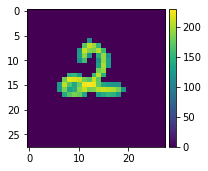

In [50]:
prueba = io.imread('/gdrive/MyDrive/Colab Notebooks/datasets/MNIST/Nuevas_muestras/a.jpg', 'rb')
prueba_1 = prep_pipe.fit_transform(prueba)
net(prueba_1)
_, result = torch.max(net(prueba_1), 1)
plt.figure(figsize=(3,3))
io.imshow(prueba_1[0,0].cpu().numpy())
print('Es un: {}'.format(result.item()))


Cabe destacar que el modelo entrenado únicamente con el 10% de la muestra no fue capaz de predecir correctamente la imagen anterior (un 2). Esto refleja la evidencia de que con cuantos más datos contemos para entrenar un modelo, mucho mejor

Las imágenes empleadas para realizar estas pruebas así como los modelos de red neuronal convolucional se encuentran en las siguietnes direcciones:

- Carpeta con varias imágenes nuevas: https://drive.google.com/drive/folders/1oWWfdZApDph_UXr_EARclyDZc7BTFQLV?usp=sharing
- Carpeta con los state_dict de las redes neuronales: https://drive.google.com/drive/folders/1RwZGgsSkOIRix6bxJ6IUsbTRFKBJ1hIX?usp=sharing

(cnn.pth corresponde al modelo entrenado con el 10% de la muestra, y cnn.pth al modelo entrenado con la dataset completo)